In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

import numpy as np

import random


In [63]:
import ipywidgets as widgets # Для игры
from IPython.display import display, clear_output

In [64]:
import matplotlib.pyplot as plt

In [61]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
class TicTacToeAgent(nn.Module):
    def __init__(self):
        super(TicTacToeAgent, self).__init__()
        # Сверточные слои для обработки состояния в виде матрицы
        N = 32
        self.conv1 = nn.Conv2d(1, N, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(N)
        self.conv2 = nn.Conv2d(N, 2*N, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(2*N)
        self.conv3 = nn.Conv2d(2*N, 4*N, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(4*N)
        # Финальный сверточный слой для получения выходного канала с вероятностями
        self.conv4 = nn.Conv2d(4*N, 1, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=0.3)
        self.player = 1

        self.start_epsilon = 1.
        self.end_epsilon = 0.01
        

    def forward(self, x):

        mask = (x != 0).float()
        
        x = x * self.player

        # Первый сверточный блок
        x = F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.1)
        x = self.dropout(x)
        
        # Второй сверточный блок
        x = F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.1)
        x = self.dropout(x)
        
        # Третий сверточный блок
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.1)
        x = self.dropout(x)
        
        # Выходной слой
        x = self.conv4(x)

        # Применяем маску, обнуляя выходные значения на занятых клетках
        x = x.masked_fill(mask == 1, float('-inf'))
        
        # Применяем softmax для получения вероятностей
        batch_size, _, height, width = x.shape
        x = x.view(batch_size, -1)  # Преобразуем в [batch_size, num_fields]
        x = x - x.max(dim=1, keepdim=True).values
        x = F.softmax(x, dim=1)     # Применяем softmax по полям
        x = x.view(batch_size, height, width)  # Восстанавливаем матрицу вероятностей
        
        return x  # Выходная матрица вероятностей
    def select_move(self, probabilities):
        # Преобразуем вероятности в одномерный вид
        batch_size, height, width = probabilities.shape
        probabilities = probabilities.view(batch_size, -1)  # [batch_size, 9]
        
        # Для каждого элемента в batch выбираем ход на основе вероятностей
        distribution = Categorical(probabilities)
        move_index = distribution.sample()  # Индекс выбранной ячейки
        
        # Преобразуем индекс в координаты строки и столбца
        row, col = divmod(move_index.item(), width)
        
        return row, col


In [3]:
# Пример использования
agent = TicTacToeAgent()
input_tensor = torch.tensor([[[[-1., -1., 0.], [1., 1., 0.], [1., 1., 0.]]]])
# input_tensor = torch.zeros(1, 1, 3, 3)  # Входная матрица 3x3
output = agent(input_tensor)
print(output)
print(output.shape)  # Ожидаемый результат: [1, 3, 3] для 3x3 входа
print(agent.select_move(output))

tensor([[[0.0000, 0.0000, 0.3975],
         [0.0000, 0.0000, 0.4038],
         [0.0000, 0.0000, 0.1987]]], grad_fn=<ViewBackward0>)
torch.Size([1, 3, 3])
(1, 2)


In [4]:
class TicTacToeEnv:
    def __init__(self, size = 3, device = 'cuda'):
        self.size = size
        self.board = torch.zeros(self.size, self.size, dtype=torch.float32).to(device=device)
        self.device = device


    def reset(self):
        self.board = torch.zeros(self.size, self.size, dtype=torch.float32).to(device=self.device)
        self.current_player = 1
        return self.board.unsqueeze(0).unsqueeze(0)  # [1, 1, 3, 3]
    
    def get_board(self):
        return self.board

    def get_valid_actions(self):
        valid_actions = (self.board == 0).nonzero(as_tuple=True)  # Получаем индексы доступных клеток
        return list(zip(valid_actions[0].tolist(), valid_actions[1].tolist()))


    def step(self, action, player):
        row, col = action
        
        if self.board[row, col] != 0:
            raise ValueError("Invalid move")
        
        self.board[row, col] = player
        reward, done = self.check_winner33()
        return self.board.unsqueeze(0).unsqueeze(0), reward * player, done

    def check_winner33(self):
        for i in range(3):
            if abs(self.board[i, :].sum()) == 3 or abs(self.board[:, i].sum()) == 3:
                return 1, True
        if abs(self.board.trace()) == 3 or abs(torch.fliplr(self.board).trace()) == 3:
            return 1, True
        if (self.board == 0).sum() == 0:
            return 0, True
        return 0, False

In [5]:
def check_victory(board):
    """
    Проверяет, есть ли победа для одного из игроков на доске.
    
    Аргументы:
        board (torch.Tensor): тензор размером (1, 1, N, N) с элементами -1, 0, 1.
        
    Возвращает:
        int: 1, если победа игрока 1; -1, если победа игрока -1; 0, если победителей нет.
    """
    board = board.squeeze()  # Удаляем размерности (1, 1, N, N) -> (N, N)
    N = board.size(0)

    # Проверяем строки и столбцы на наличие тройки подряд
    for i in range(N):
        for j in range(N - 2):  # Проходим по всем возможным начальным индексам тройки
            # Проверка строки
            if board[i, j] == board[i, j + 1] == board[i, j + 2] and board[i, j] != 0:
                return board[i, j]
            # Проверка столбца
            if board[j, i] == board[j + 1, i] == board[j + 2, i] and board[j, i] != 0:
                return board[j, i]
    
    # Проверяем диагонали на наличие тройки подряд
    for i in range(N - 2):
        for j in range(N - 2):
            # Проверка главной диагонали
            if board[i, j] == board[i + 1, j + 1] == board[i + 2, j + 2] and board[i, j] != 0:
                return board[i, j]
            # Проверка побочной диагонали
            if board[i, j + 2] == board[i + 1, j + 1] == board[i + 2, j] and board[i, j + 2] != 0:
                return board[i, j + 2]
    
    # Если нет победителя
    return 0

# Пример использования
board = torch.tensor([[[[0, 1, -1],
                        [-1, -1, 1],
                        [-1, 0, 0]
                        ]]])  # Размер (1, 1, 4, 4)

result = check_victory(board)
if result == 1:
    print("Победа игрока 1")
elif result == -1:
    print("Победа игрока -1")
else:
    print("Ничья")

Победа игрока -1


In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Пример использования с вашей моделью

print(f"Количество обучаемых параметров: {count_parameters(agent)}")

Количество обучаемых параметров: 94273


In [ ]:
def agent_eval(agent, env, num_games=100):
    """
    Оценка процента побед агента:
    - Против случайного игрока.
    :param agent: Агент, который делает предсказания ходов.
    :param env: Среда игры.
    :param num_games: Количество игр для оценки.
    :return: Словарь с процентами побед.
    """
    def play_game(agent):
        """Запуск одной игры между двумя агентами."""
        env.reset()
        done = False
        player = 1

        while not done:
            state = env.board.unsqueeze(0).unsqueeze(0) * player
            if player == 1:
                probabilities = agent(state)
                row, col = agent.select_move(probabilities) # Здесь по идее надо поменять на аргмакс
            else:
                # Если agent2 — случайный игрок, выбираем случайный ход
                valid_actions = env.get_valid_actions()
                if valid_actions:
                    row, col = random.choice(valid_actions)
                

            # Применяем ход
            _, reward, done = env.step((row, col), player)
            player *= -1

        return reward  # 1 = победа первого игрока, -1 = победа второго игрока, 0 = ничья

    def evaluate(agent):
        """Оценка процента побед первого агента."""
        results = {"agent1_wins": 0, "agent2_wins": 0, "draws": 0}

        for _ in range(num_games):
            winner = play_game(agent)
            if winner == 1:
                results["agent1_wins"] += 1
            elif winner == -1:
                results["agent2_wins"] += 1
            else:
                results["draws"] += 1

        total_games = num_games
        results["agent1_win_rate"] = results["agent1_wins"] / total_games * 100
        results["agent2_win_rate"] = results["agent2_wins"] / total_games * 100
        results["draw_rate"] = results["draws"] / total_games * 100
        return results


    # Оценка против случайного игрока
    print("Evaluating against random player...")
    with torch.no_grad():
        random_play_results = evaluate(agent.eval())
    agent.train()
    return {
        "random_play": random_play_results
    }

In [ ]:
## 1 версия

agent = TicTacToeAgent().to(device=DEVICE)
optimizer = optim.AdamW(agent.parameters(), lr=0.0001, weight_decay=1e-4)
env = TicTacToeEnv(device=DEVICE)

num_episodes = 50000
gamma = 0.99  # Коэффициент дисконтирования

eps = 0.5
eps_min = 0.05
decay = 0.9999

vals = []

for episode in range(num_episodes):
    state = env.reset()
    log_probs = []
    rewards = []
    done = False

    while not done:
        # Получение вероятностей для действий
        probabilities = agent(state)
        if random.random() < eps:
            actions = env.get_valid_actions()
            if actions:
                row, col = random.choice(actions)
        else:
            row, col = agent.select_move(probabilities)

        # Выполнение действия в среде
        next_state, reward, done = env.step((row, col), agent.player)

        # Сохранение логарифма вероятности выбранного действия
        log_prob = torch.log(probabilities[0, row, col])
        log_probs.append(log_prob)

        # Сохранение вознаграждения
        rewards.append(reward * agent.player)
        
        agent.player *=-1
        state = next_state



    returns = []
    G = 0
    player = 1
    for r in reversed(rewards):
        G = r + gamma * G
        G = G * player
        player *=-1
        returns.insert(0, G)
    returns = torch.tensor(returns)

    # Нормализация
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    # Вычисление функции потерь
    loss = torch.stack([-log_prob * G for log_prob, G in zip(log_probs, returns)]).sum()
    loss = loss.clamp(min=-10, max=10)
    # Обновление параметров модели
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    eps = max(eps_min, eps*decay)

    if episode % 1000 == 0:
        eval = agent_eval(agent=agent, env=env, num_games=100)
        print(f"{episode=}, {eval}")
        print(f"{loss=}")
        vals.append(eval)

Evaluating against random player...
episode=0, {'random_play': {'agent1_wins': 60, 'agent2_wins': 29, 'draws': 11, 'agent1_win_rate': 60.0, 'agent2_win_rate': 28.999999999999996, 'draw_rate': 11.0}}
loss=tensor(0., device='cuda:0', grad_fn=<ClampBackward1>)
Evaluating against random player...
episode=1000, {'random_play': {'agent1_wins': 58, 'agent2_wins': 28, 'draws': 14, 'agent1_win_rate': 57.99999999999999, 'agent2_win_rate': 28.000000000000004, 'draw_rate': 14.000000000000002}}
loss=tensor(7.5285, device='cuda:0', grad_fn=<ClampBackward1>)
Evaluating against random player...
episode=2000, {'random_play': {'agent1_wins': 66, 'agent2_wins': 16, 'draws': 18, 'agent1_win_rate': 66.0, 'agent2_win_rate': 16.0, 'draw_rate': 18.0}}
loss=tensor(-10., device='cuda:0', grad_fn=<ClampBackward1>)
Evaluating against random player...
episode=3000, {'random_play': {'agent1_wins': 70, 'agent2_wins': 24, 'draws': 6, 'agent1_win_rate': 70.0, 'agent2_win_rate': 24.0, 'draw_rate': 6.0}}
loss=tensor(-10

In [68]:
def plot_results(vals):
    """
    Визуализирует win_rate и draw_rate для списка результатов.
    
    Аргументы:
        vals (list[dict]): Список, где каждый элемент содержит метрики: 'agent1_win_rate', 'agent2_win_rate', 'draw_rate'.
    """
    # Проверяем корректность входных данных
    if not vals or not isinstance(vals[0], dict):
        raise ValueError("`vals` должен быть списком словарей с результатами.")
    
    # Инициализация списков для хранения значений
    x_values = list(range(0, len(vals) * 1000, 1000))
    agent1_win_rates = []
    agent2_win_rates = []
    draw_rates = []

    # Извлечение данных
    for result in vals:
        key = next(iter(result))  # Достаем ключ верхнего уровня
        metrics = result[key]
        agent1_win_rates.append(metrics['agent1_win_rate'])
        agent2_win_rates.append(metrics['agent2_win_rate'])
        draw_rates.append(metrics['draw_rate'])
    
    # Построение графика
    plt.figure(figsize=(12, 6))
    plt.plot(x_values, agent1_win_rates, label="Agent 1 Win Rate", color="blue")
    plt.plot(x_values, agent2_win_rates, label="Agent 2 Win Rate", color="orange")
    plt.plot(x_values, draw_rates, label="Draw Rate", color="green")
    
    plt.title("Win Rates and Draw Rate Over Time", fontsize=16)
    plt.xlabel("Steps", fontsize=14)
    plt.ylabel("Rate (%)", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

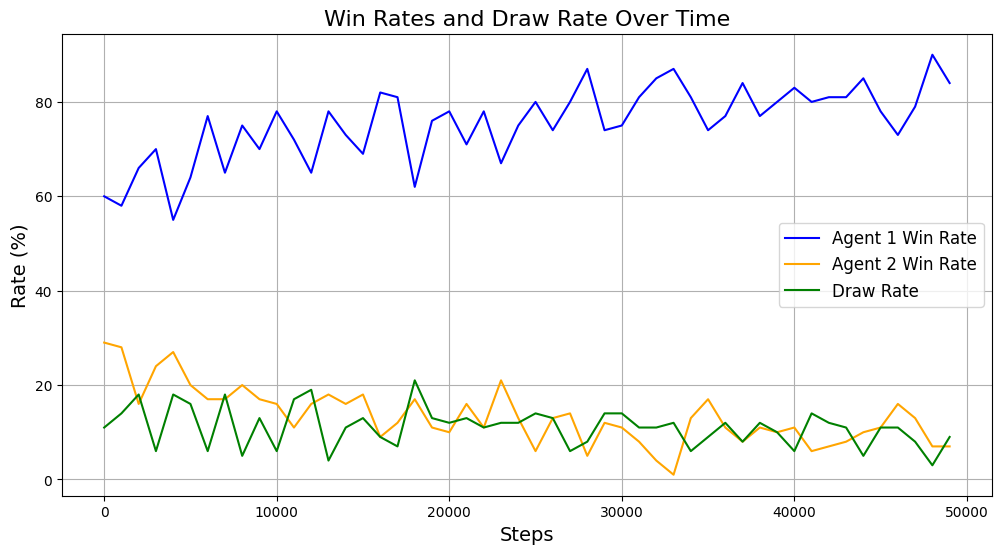

In [69]:
plot_results(vals)

In [ ]:
# torch.save(agent.state_dict(), "agent_weights.pth")

In [ ]:
ag = TicTacToeAgent()
ag.load_state_dict(torch.load("agent_weights.pth", weights_only = True))
ag.to(device=DEVICE)

<All keys matched successfully>

In [ ]:
env = TicTacToeEnv(device=DEVICE)
env.reset()
# Оценка агента
results = agent_eval(agent, env)
print(results)

Evaluating against random player...
{'random_play': {'agent1_wins': 93, 'agent2_wins': 0, 'draws': 7, 'agent1_win_rate': 93.0, 'agent2_win_rate': 0.0, 'draw_rate': 7.000000000000001}}


In [ ]:
class TicTacToeWithAgent:
    def __init__(self, agent, check_winner_func, board_size=3, device = 'cuda'):
        self.board_size = board_size
        self.device = device
        self.board = torch.zeros((1, 1, board_size, board_size), dtype=torch.float32).to(device=self.device )
        self.current_player = 1  # Игрок 1 - человек, Игрок -1 - агент
        self.agent = agent  # Функция агента
        self.check_winner = check_winner_func  # Функция проверки победы
        self.buttons = [widgets.Button(description=" ") for _ in range(board_size * board_size)]
        self.output = widgets.Output()
        self.restart_button = widgets.Button(description="Restart", button_style="danger")
        self.create_ui()

    def create_ui(self):
        grid = widgets.GridBox(
            children=self.buttons,
            layout=widgets.Layout(
                grid_template_columns=f"repeat({self.board_size}, 100px)",
                grid_template_rows=f"repeat({self.board_size}, 100px)",
                grid_gap="5px",
            ),
        )
        for i, button in enumerate(self.buttons):
            button.on_click(lambda b, i=i: self.make_human_move(i))
        
        self.restart_button.on_click(lambda b: self.restart_game())
        display(grid, self.restart_button, self.output)

    def make_human_move(self, index):
        x, y = divmod(index, self.board_size)
        if self.board[0, 0, x, y] == 0 and self.current_player == 1:
            self.board[0, 0, x, y] = self.current_player
            self.update_button(index, self.current_player)
            self.check_game_status()

            if self.current_player == -1:  # Если игра продолжается, ход агента
                self.make_agent_move()

    def make_agent_move(self):
        self.agent.player = -1
        probs = self.agent(self.board)
        # row, col = self.agent.select_move(probs)  # Агент выбирает оптимальный ход
        flat_index = torch.argmax(probs).item()
        row, col = divmod(flat_index, probs.shape[1])
        if self.board[0, 0, row, col] == 0:  # Если клетка пуста
            self.board[0, 0, row, col] = -1  # Агент делает ход (-1)
            self.update_ui_from_board()  # Обновляем интерфейс
            self.check_game_status()  # Проверяем статус игры


    def check_game_status(self):
        winner = self.check_winner(self.board)
        if winner != 0:
            with self.output:
                clear_output()
                if winner == 1:
                    print("Player wins!")
                elif winner == -1:
                    print("Agent wins!")
            self.disable_all_buttons()
        elif (self.board == 0).sum().item() == 0:  # Ничья
            with self.output:
                clear_output()
                print("It's a draw!")
        else:
            self.current_player *= -1  # Смена игрока

    def update_button(self, index, player):
        self.buttons[index].description = "X" if player == 1 else "O"
        self.buttons[index].disabled = True

    def update_ui_from_board(self):
        for i in range(self.board_size * self.board_size):
            x, y = divmod(i, self.board_size)
            value = self.board[0, 0, x, y].item()
            if value == 1:
                self.buttons[i].description = "X"
                self.buttons[i].disabled = True
            elif value == -1:
                self.buttons[i].description = "O"
                self.buttons[i].disabled = True
            else:
                self.buttons[i].description = " "
                self.buttons[i].disabled = False

    def disable_all_buttons(self):
        for button in self.buttons:
            button.disabled = True

    def restart_game(self):
        self.board = torch.zeros((1, 1, self.board_size, self.board_size), dtype=torch.float32).to(device=self.device )
        self.current_player = 1
        for button in self.buttons:
            button.description = " "
            button.disabled = False
        with self.output:
            clear_output()


# Пример функции проверки победы
def check_winner_func(board):
    # Аргумент board: тензор (1, 1, N, N)
    board = board[0, 0]
    N = board.shape[0]
    for i in range(N):
        if torch.abs(board[i, :].sum()) == N:  # Горизонтали
            return board[i, 0].item()
        if torch.abs(board[:, i].sum()) == N:  # Вертикали
            return board[0, i].item()
    if torch.abs(board.diag().sum()) == N:  # Главная диагональ
        return board[0, 0].item()
    if torch.abs(torch.flip(board, dims=[1]).diag().sum()) == N:  # Побочная диагональ
        return board[0, N - 1].item()
    return 0  # Победителя нет

# Пример агента, который делает случайный ход
def random_agent(board):
    empty_positions = (board[0, 0] == 0).nonzero(as_tuple=False)
    if len(empty_positions) > 0:
        move = empty_positions[torch.randint(len(empty_positions), (1,))].tolist()
        board[0, 0, move[0], move[1]] = -1  # Агент всегда играет -1
    return board


# Запуск игры
TicTacToeWithAgent(agent=ag, check_winner_func=check_victory, board_size=4, device=DEVICE)

GridBox(children=(Button(description=' ', style=ButtonStyle()), Button(description=' ', style=ButtonStyle()), …

Button(button_style='danger', description='Restart', style=ButtonStyle())

Output()